# Stock Forecasting with Convolution and LSTM

with Eric Wolos

The objective of this project is to compare the forecasting abilities of different deep learning networks that use LSTM (Long Short Term Memory) cells, or the novel Wavenet architecture, which uses entirely convolution.

For a baseline comparison, these models will be compared to a naive forecast with the metric of mean absolute percentage error.

## Download and Visualize Data

In [1]:
import datetime as dt
import pandas_datareader.data as pd_web
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ticker = "NVDA"
previousdays = 1800

In [3]:
# Function to return dataframe of stock data between today and previous n days, where n is daysPast.
# Note that daysPast includes weekends and holidays, even though there is no data on these days.

def getPresentStockData(ticker, daysPast):
    final_date =  dt.date.today() + dt.timedelta(-1*daysPast)
    new_data = pd_web.DataReader(ticker, 'yahoo', final_date)
    return new_data

In [4]:
data = getPresentStockData(ticker,previousdays)

In [5]:
series = data['Adj Close']

To get an accurate sense of how well models might perform, the data is broken up into training (80%), validation (10%), and testing (10%) datasets. Models are trained on training data, tuned on performance with validation data, and finally tested with testing data.

In [6]:
test_ratio = 0.1
val_ratio = 0.1
train_ratio = 1 - test_ratio - val_ratio

In [7]:
testStartTime = int(len(series)*(train_ratio + val_ratio))
trainEndTime = int(len(series)*train_ratio)

In [8]:
testDates = series.index[testStartTime:]
testValues = series[testStartTime:]

trainDates = series.index[:testStartTime]
trainValues = series[:testStartTime]

valDates = series.index[trainEndTime:(testStartTime+1)]
valValues = series[trainEndTime:(testStartTime+1)]

Let's visualize our data first to see how it looks over time.

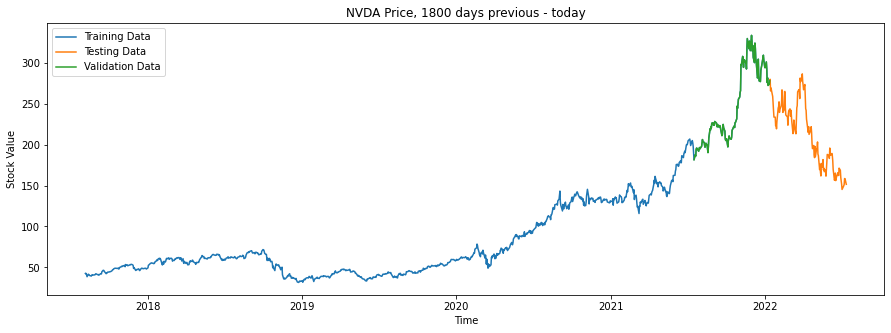

In [9]:
fig = plt.figure(figsize=(15,5))
plt.plot(trainDates,trainValues)
plt.plot(testDates,testValues)
plt.plot(valDates,valValues)
plt.legend(["Training Data","Testing Data", "Validation Data"])
plt.xlabel("Time")
plt.ylabel("Stock Value")
plt.title(f"{ticker} Price, {previousdays} days previous - today")
plt.show()

## Establishing a Baseline

Let's get a feel for how a naive model might predict the market by looking at its performance with the metric of mean absolute percentage error.

This naive forecast will form a rough baseline so that we have an effective comparative tool for market projections.

In [10]:
# The naive forecast rows are the date the forecast comes from and the price that of that date. 
# Its index corresponds to the day forecasted in testValues
# For instance, naiveForecast[0] is the forecasted price for the first day of testValues.

naiveForecast = series[-(len(testValues)+1):].drop(testValues.index[-1])
nMAPE = tf.keras.metrics.mean_absolute_percentage_error(testValues, naiveForecast).numpy()
print(f"The Mean Absolute Percent Error for the Niave Forecast is {nMAPE}%")

The Mean Absolute Percent Error for the Niave Forecast is 3.591197358504809%


In [11]:
valueRange = max(series) - min(series)

## LSTM Neural Network

In [12]:
def windowDS(series, batchSize, windowSize):
    series = tf.expand_dims(series, axis = -1)
    slices = tf.data.Dataset.from_tensor_slices(series)
    windowSlices = slices.window(windowSize+1, shift = 1, drop_remainder=True)
    tensors = windowSlices.flat_map(lambda x: x.batch(windowSize+1))
    tensors = tensors.map(lambda x: (x[:-1], x[-1:]))
    tensors = tensors.shuffle(buffer_size = len(series) + 1) 
    batches = tensors.batch(batchSize).prefetch(1)
    return batches

In [13]:
windowSize = 1
batchSize = 32

train = windowDS(trainValues, batchSize, windowSize)
val = windowDS(valValues, batchSize, windowSize)

In [14]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, 
                           kernel_size=5,
                           strides=1, 
                           padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 15 * valueRange)
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 32)          6272      
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          8320      
                                                                 
 dense (Dense)               (None, None, 1)           33        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________


In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-9, momentum=0.9)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(),
              metrics = [tf.keras.metrics.MeanAbsolutePercentageError()]
)


In [17]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("TScheckpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50,min_delta = 0.01)

class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
resetStates = ResetStatesCallback()

In [18]:
LSTMhistory = model.fit(train,
          epochs=1000,
          validation_data=val,
          callbacks = [model_checkpoint,early_stopping, resetStates])

Epoch 1/1000
35/35 [==============================] - 4s 33ms/step - loss: 103.9119 - mean_absolute_percentage_error: 98.3506 - val_loss: 335.0613 - val_mean_absolute_percentage_error: 136.1228
Epoch 2/1000
35/35 [==============================] - 0s 4ms/step - loss: 102.3560 - mean_absolute_percentage_error: 99.0572 - val_loss: 329.5208 - val_mean_absolute_percentage_error: 133.7761
Epoch 3/1000
35/35 [==============================] - 0s 4ms/step - loss: 100.6970 - mean_absolute_percentage_error: 97.3008 - val_loss: 326.7760 - val_mean_absolute_percentage_error: 132.6006
Epoch 4/1000
35/35 [==============================] - 0s 4ms/step - loss: 98.9649 - mean_absolute_percentage_error: 95.9478 - val_loss: 322.0515 - val_mean_absolute_percentage_error: 130.5827
Epoch 5/1000
35/35 [==============================] - 0s 4ms/step - loss: 96.9774 - mean_absolute_percentage_error: 94.3276 - val_loss: 316.3858 - val_mean_absolute_percentage_error: 128.1629
Epoch 6/1000
35/35 [================

Epoch 44/1000
35/35 [==============================] - 0s 4ms/step - loss: 15.5482 - mean_absolute_percentage_error: 8.6849 - val_loss: 100.6977 - val_mean_absolute_percentage_error: 39.1108
Epoch 45/1000
35/35 [==============================] - 0s 3ms/step - loss: 14.7721 - mean_absolute_percentage_error: 8.3517 - val_loss: 97.2261 - val_mean_absolute_percentage_error: 37.6823
Epoch 46/1000
35/35 [==============================] - 0s 3ms/step - loss: 14.1009 - mean_absolute_percentage_error: 8.1102 - val_loss: 93.7933 - val_mean_absolute_percentage_error: 36.2741
Epoch 47/1000
35/35 [==============================] - 0s 3ms/step - loss: 13.4903 - mean_absolute_percentage_error: 7.8884 - val_loss: 90.4625 - val_mean_absolute_percentage_error: 34.9137
Epoch 48/1000
35/35 [==============================] - 0s 3ms/step - loss: 12.9578 - mean_absolute_percentage_error: 7.7148 - val_loss: 87.5759 - val_mean_absolute_percentage_error: 33.7428
Epoch 49/1000
35/35 [============================

35/35 [==============================] - 0s 3ms/step - loss: 5.8209 - mean_absolute_percentage_error: 4.0998 - val_loss: 36.7614 - val_mean_absolute_percentage_error: 13.7382
Epoch 88/1000
35/35 [==============================] - 0s 3ms/step - loss: 5.7849 - mean_absolute_percentage_error: 4.0949 - val_loss: 36.8572 - val_mean_absolute_percentage_error: 13.7850
Epoch 89/1000
35/35 [==============================] - 0s 3ms/step - loss: 5.7557 - mean_absolute_percentage_error: 4.0904 - val_loss: 35.8285 - val_mean_absolute_percentage_error: 13.3598
Epoch 90/1000
35/35 [==============================] - 0s 3ms/step - loss: 5.7147 - mean_absolute_percentage_error: 4.0738 - val_loss: 36.0085 - val_mean_absolute_percentage_error: 13.4416
Epoch 91/1000
35/35 [==============================] - 0s 3ms/step - loss: 5.6820 - mean_absolute_percentage_error: 4.0695 - val_loss: 36.0871 - val_mean_absolute_percentage_error: 13.4800
Epoch 92/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 4ms/step - loss: 4.8330 - mean_absolute_percentage_error: 3.7956 - val_loss: 28.4536 - val_mean_absolute_percentage_error: 10.4255
Epoch 131/1000
35/35 [==============================] - 0s 3ms/step - loss: 4.8200 - mean_absolute_percentage_error: 3.7981 - val_loss: 28.1075 - val_mean_absolute_percentage_error: 10.2846
Epoch 132/1000
35/35 [==============================] - 0s 3ms/step - loss: 4.7993 - mean_absolute_percentage_error: 3.7838 - val_loss: 28.3328 - val_mean_absolute_percentage_error: 10.3821
Epoch 133/1000
35/35 [==============================] - 0s 3ms/step - loss: 4.7851 - mean_absolute_percentage_error: 3.7867 - val_loss: 28.2258 - val_mean_absolute_percentage_error: 10.3401
Epoch 134/1000
35/35 [==============================] - 0s 3ms/step - loss: 4.7782 - mean_absolute_percentage_error: 3.7853 - val_loss: 27.8920 - val_mean_absolute_percentage_error: 10.2033
Epoch 135/1000
35/35 [==============================] - 0s 3ms/st

35/35 [==============================] - 0s 3ms/step - loss: 4.2429 - mean_absolute_percentage_error: 3.5003 - val_loss: 24.1060 - val_mean_absolute_percentage_error: 8.7434
Epoch 174/1000
35/35 [==============================] - 0s 3ms/step - loss: 4.2239 - mean_absolute_percentage_error: 3.4800 - val_loss: 24.8921 - val_mean_absolute_percentage_error: 9.0698
Epoch 175/1000
35/35 [==============================] - 0s 3ms/step - loss: 4.2117 - mean_absolute_percentage_error: 3.4774 - val_loss: 24.3865 - val_mean_absolute_percentage_error: 8.8651
Epoch 176/1000
35/35 [==============================] - 0s 3ms/step - loss: 4.2085 - mean_absolute_percentage_error: 3.4792 - val_loss: 24.2508 - val_mean_absolute_percentage_error: 8.8111
Epoch 177/1000
35/35 [==============================] - 0s 3ms/step - loss: 4.1929 - mean_absolute_percentage_error: 3.4682 - val_loss: 24.2429 - val_mean_absolute_percentage_error: 8.8098
Epoch 178/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 3.8177 - mean_absolute_percentage_error: 3.2017 - val_loss: 21.6566 - val_mean_absolute_percentage_error: 7.8352
Epoch 217/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.8219 - mean_absolute_percentage_error: 3.2328 - val_loss: 21.5695 - val_mean_absolute_percentage_error: 7.8020
Epoch 218/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.8147 - mean_absolute_percentage_error: 3.2023 - val_loss: 21.6398 - val_mean_absolute_percentage_error: 7.8309
Epoch 219/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.8049 - mean_absolute_percentage_error: 3.2049 - val_loss: 21.9708 - val_mean_absolute_percentage_error: 7.9632
Epoch 220/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.7915 - mean_absolute_percentage_error: 3.1999 - val_loss: 21.8022 - val_mean_absolute_percentage_error: 7.8979
Epoch 221/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 3.5511 - mean_absolute_percentage_error: 3.0354 - val_loss: 20.0527 - val_mean_absolute_percentage_error: 7.2581
Epoch 260/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.5599 - mean_absolute_percentage_error: 3.0528 - val_loss: 20.2464 - val_mean_absolute_percentage_error: 7.3358
Epoch 261/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.5391 - mean_absolute_percentage_error: 3.0361 - val_loss: 20.3085 - val_mean_absolute_percentage_error: 7.3620
Epoch 262/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.5240 - mean_absolute_percentage_error: 3.0010 - val_loss: 20.0990 - val_mean_absolute_percentage_error: 7.2807
Epoch 263/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.5229 - mean_absolute_percentage_error: 3.0172 - val_loss: 19.7901 - val_mean_absolute_percentage_error: 7.1581
Epoch 264/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 3.3473 - mean_absolute_percentage_error: 2.9268 - val_loss: 18.4420 - val_mean_absolute_percentage_error: 6.6697
Epoch 303/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.3485 - mean_absolute_percentage_error: 2.9165 - val_loss: 18.4220 - val_mean_absolute_percentage_error: 6.6624
Epoch 304/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.3258 - mean_absolute_percentage_error: 2.8812 - val_loss: 18.5258 - val_mean_absolute_percentage_error: 6.7046
Epoch 305/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.3252 - mean_absolute_percentage_error: 2.8800 - val_loss: 18.3587 - val_mean_absolute_percentage_error: 6.6397
Epoch 306/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.3263 - mean_absolute_percentage_error: 2.8935 - val_loss: 18.2767 - val_mean_absolute_percentage_error: 6.6071
Epoch 307/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 3.1764 - mean_absolute_percentage_error: 2.7958 - val_loss: 17.0921 - val_mean_absolute_percentage_error: 6.1759
Epoch 346/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.1908 - mean_absolute_percentage_error: 2.8242 - val_loss: 17.4131 - val_mean_absolute_percentage_error: 6.3028
Epoch 347/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.1788 - mean_absolute_percentage_error: 2.8092 - val_loss: 17.6070 - val_mean_absolute_percentage_error: 6.3816
Epoch 348/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.1805 - mean_absolute_percentage_error: 2.8027 - val_loss: 17.2179 - val_mean_absolute_percentage_error: 6.2280
Epoch 349/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.1716 - mean_absolute_percentage_error: 2.7975 - val_loss: 17.6071 - val_mean_absolute_percentage_error: 6.3829
Epoch 350/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 3.0694 - mean_absolute_percentage_error: 2.7890 - val_loss: 16.6172 - val_mean_absolute_percentage_error: 6.0227
Epoch 389/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.0650 - mean_absolute_percentage_error: 2.7456 - val_loss: 16.5200 - val_mean_absolute_percentage_error: 5.9853
Epoch 390/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.0533 - mean_absolute_percentage_error: 2.7486 - val_loss: 16.6826 - val_mean_absolute_percentage_error: 6.0497
Epoch 391/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.0466 - mean_absolute_percentage_error: 2.7240 - val_loss: 16.3430 - val_mean_absolute_percentage_error: 5.9189
Epoch 392/1000
35/35 [==============================] - 0s 3ms/step - loss: 3.0468 - mean_absolute_percentage_error: 2.7310 - val_loss: 16.1932 - val_mean_absolute_percentage_error: 5.8627
Epoch 393/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 2.9473 - mean_absolute_percentage_error: 2.6902 - val_loss: 15.4200 - val_mean_absolute_percentage_error: 5.5880
Epoch 432/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.9440 - mean_absolute_percentage_error: 2.6903 - val_loss: 15.5651 - val_mean_absolute_percentage_error: 5.6445
Epoch 433/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.9399 - mean_absolute_percentage_error: 2.6845 - val_loss: 15.8001 - val_mean_absolute_percentage_error: 5.7347
Epoch 434/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.9385 - mean_absolute_percentage_error: 2.6844 - val_loss: 16.0187 - val_mean_absolute_percentage_error: 5.8195
Epoch 435/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.9282 - mean_absolute_percentage_error: 2.6584 - val_loss: 15.5525 - val_mean_absolute_percentage_error: 5.6414
Epoch 436/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 2.8487 - mean_absolute_percentage_error: 2.6342 - val_loss: 15.0916 - val_mean_absolute_percentage_error: 5.4836
Epoch 475/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.8455 - mean_absolute_percentage_error: 2.6268 - val_loss: 14.9367 - val_mean_absolute_percentage_error: 5.4241
Epoch 476/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.8458 - mean_absolute_percentage_error: 2.6337 - val_loss: 15.0237 - val_mean_absolute_percentage_error: 5.4583
Epoch 477/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.8417 - mean_absolute_percentage_error: 2.6175 - val_loss: 14.9578 - val_mean_absolute_percentage_error: 5.4331
Epoch 478/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.8384 - mean_absolute_percentage_error: 2.6115 - val_loss: 14.7407 - val_mean_absolute_percentage_error: 5.3506
Epoch 479/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 4ms/step - loss: 2.7745 - mean_absolute_percentage_error: 2.5915 - val_loss: 14.1888 - val_mean_absolute_percentage_error: 5.1578
Epoch 518/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.7727 - mean_absolute_percentage_error: 2.6000 - val_loss: 14.3407 - val_mean_absolute_percentage_error: 5.2159
Epoch 519/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.7713 - mean_absolute_percentage_error: 2.5887 - val_loss: 14.4567 - val_mean_absolute_percentage_error: 5.2602
Epoch 520/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.7704 - mean_absolute_percentage_error: 2.5929 - val_loss: 14.5101 - val_mean_absolute_percentage_error: 5.2801
Epoch 521/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.7659 - mean_absolute_percentage_error: 2.5874 - val_loss: 14.4836 - val_mean_absolute_percentage_error: 5.2709
Epoch 522/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 2.6966 - mean_absolute_percentage_error: 2.5539 - val_loss: 13.9180 - val_mean_absolute_percentage_error: 5.0715
Epoch 561/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.6925 - mean_absolute_percentage_error: 2.5453 - val_loss: 13.7910 - val_mean_absolute_percentage_error: 5.0234
Epoch 562/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.6976 - mean_absolute_percentage_error: 2.5623 - val_loss: 13.9410 - val_mean_absolute_percentage_error: 5.0809
Epoch 563/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.6895 - mean_absolute_percentage_error: 2.5574 - val_loss: 13.8347 - val_mean_absolute_percentage_error: 5.0406
Epoch 564/1000
35/35 [==============================] - 0s 4ms/step - loss: 2.6912 - mean_absolute_percentage_error: 2.5478 - val_loss: 13.9889 - val_mean_absolute_percentage_error: 5.1002
Epoch 565/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 2.6269 - mean_absolute_percentage_error: 2.5266 - val_loss: 13.5364 - val_mean_absolute_percentage_error: 4.9409
Epoch 604/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.6299 - mean_absolute_percentage_error: 2.5263 - val_loss: 13.4601 - val_mean_absolute_percentage_error: 4.9129
Epoch 605/1000
35/35 [==============================] - 0s 4ms/step - loss: 2.6313 - mean_absolute_percentage_error: 2.5274 - val_loss: 12.9054 - val_mean_absolute_percentage_error: 4.7136
Epoch 606/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.6366 - mean_absolute_percentage_error: 2.5584 - val_loss: 13.9131 - val_mean_absolute_percentage_error: 5.0849
Epoch 607/1000
35/35 [==============================] - 0s 4ms/step - loss: 2.6573 - mean_absolute_percentage_error: 2.5578 - val_loss: 13.1612 - val_mean_absolute_percentage_error: 4.8017
Epoch 608/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 2.5775 - mean_absolute_percentage_error: 2.5094 - val_loss: 12.8340 - val_mean_absolute_percentage_error: 4.6911
Epoch 647/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.5730 - mean_absolute_percentage_error: 2.4951 - val_loss: 13.0512 - val_mean_absolute_percentage_error: 4.7708
Epoch 648/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.5729 - mean_absolute_percentage_error: 2.4921 - val_loss: 12.9042 - val_mean_absolute_percentage_error: 4.7152
Epoch 649/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.5679 - mean_absolute_percentage_error: 2.4881 - val_loss: 13.1553 - val_mean_absolute_percentage_error: 4.8112
Epoch 650/1000
35/35 [==============================] - 0s 4ms/step - loss: 2.5805 - mean_absolute_percentage_error: 2.4911 - val_loss: 12.7301 - val_mean_absolute_percentage_error: 4.6557
Epoch 651/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 2.5256 - mean_absolute_percentage_error: 2.4762 - val_loss: 12.5987 - val_mean_absolute_percentage_error: 4.6124
Epoch 690/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.5311 - mean_absolute_percentage_error: 2.5060 - val_loss: 12.4295 - val_mean_absolute_percentage_error: 4.5543
Epoch 691/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.5185 - mean_absolute_percentage_error: 2.4673 - val_loss: 12.3413 - val_mean_absolute_percentage_error: 4.5239
Epoch 692/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.5197 - mean_absolute_percentage_error: 2.4778 - val_loss: 12.5515 - val_mean_absolute_percentage_error: 4.5963
Epoch 693/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.5290 - mean_absolute_percentage_error: 2.4841 - val_loss: 12.5025 - val_mean_absolute_percentage_error: 4.5792
Epoch 694/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 4ms/step - loss: 2.4751 - mean_absolute_percentage_error: 2.4550 - val_loss: 12.1912 - val_mean_absolute_percentage_error: 4.4738
Epoch 733/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.4774 - mean_absolute_percentage_error: 2.4659 - val_loss: 12.0161 - val_mean_absolute_percentage_error: 4.4149
Epoch 734/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.4892 - mean_absolute_percentage_error: 2.4633 - val_loss: 11.9485 - val_mean_absolute_percentage_error: 4.3923
Epoch 735/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.4737 - mean_absolute_percentage_error: 2.4582 - val_loss: 12.0530 - val_mean_absolute_percentage_error: 4.4269
Epoch 736/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.4775 - mean_absolute_percentage_error: 2.4637 - val_loss: 12.1331 - val_mean_absolute_percentage_error: 4.4543
Epoch 737/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 2.4327 - mean_absolute_percentage_error: 2.4234 - val_loss: 11.7004 - val_mean_absolute_percentage_error: 4.3091
Epoch 776/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.4454 - mean_absolute_percentage_error: 2.4546 - val_loss: 11.9059 - val_mean_absolute_percentage_error: 4.3778
Epoch 777/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.4406 - mean_absolute_percentage_error: 2.4360 - val_loss: 11.7501 - val_mean_absolute_percentage_error: 4.3259
Epoch 778/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.4327 - mean_absolute_percentage_error: 2.4347 - val_loss: 11.7686 - val_mean_absolute_percentage_error: 4.3320
Epoch 779/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.4280 - mean_absolute_percentage_error: 2.4305 - val_loss: 11.9554 - val_mean_absolute_percentage_error: 4.3952
Epoch 780/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 2.4017 - mean_absolute_percentage_error: 2.4234 - val_loss: 11.6812 - val_mean_absolute_percentage_error: 4.3024
Epoch 819/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.4054 - mean_absolute_percentage_error: 2.4389 - val_loss: 11.4507 - val_mean_absolute_percentage_error: 4.2253
Epoch 820/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.4029 - mean_absolute_percentage_error: 2.4301 - val_loss: 11.6473 - val_mean_absolute_percentage_error: 4.2905
Epoch 821/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.3953 - mean_absolute_percentage_error: 2.4290 - val_loss: 11.4431 - val_mean_absolute_percentage_error: 4.2228
Epoch 822/1000
35/35 [==============================] - 0s 4ms/step - loss: 2.3994 - mean_absolute_percentage_error: 2.4444 - val_loss: 11.1902 - val_mean_absolute_percentage_error: 4.1389
Epoch 823/1000
35/35 [==============================] - 0s 4ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 2.3695 - mean_absolute_percentage_error: 2.4222 - val_loss: 11.1150 - val_mean_absolute_percentage_error: 4.1121
Epoch 862/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.3764 - mean_absolute_percentage_error: 2.4571 - val_loss: 11.0908 - val_mean_absolute_percentage_error: 4.1043
Epoch 863/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.3572 - mean_absolute_percentage_error: 2.4077 - val_loss: 11.1301 - val_mean_absolute_percentage_error: 4.1166
Epoch 864/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.3715 - mean_absolute_percentage_error: 2.4216 - val_loss: 11.3686 - val_mean_absolute_percentage_error: 4.1975
Epoch 865/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.3729 - mean_absolute_percentage_error: 2.4392 - val_loss: 11.1533 - val_mean_absolute_percentage_error: 4.1245
Epoch 866/1000
35/35 [==============================] - 0s 4ms/step - 

35/35 [==============================] - 0s 4ms/step - loss: 2.3397 - mean_absolute_percentage_error: 2.4375 - val_loss: 10.5981 - val_mean_absolute_percentage_error: 3.9459
Epoch 905/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.3368 - mean_absolute_percentage_error: 2.4189 - val_loss: 10.8136 - val_mean_absolute_percentage_error: 4.0123
Epoch 906/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.3336 - mean_absolute_percentage_error: 2.4008 - val_loss: 11.0041 - val_mean_absolute_percentage_error: 4.0751
Epoch 907/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.3285 - mean_absolute_percentage_error: 2.4037 - val_loss: 10.7936 - val_mean_absolute_percentage_error: 4.0055
Epoch 908/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.3539 - mean_absolute_percentage_error: 2.4462 - val_loss: 10.8435 - val_mean_absolute_percentage_error: 4.0220
Epoch 909/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 2.2970 - mean_absolute_percentage_error: 2.3792 - val_loss: 10.6076 - val_mean_absolute_percentage_error: 3.9434
Epoch 948/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.3003 - mean_absolute_percentage_error: 2.3968 - val_loss: 10.6382 - val_mean_absolute_percentage_error: 3.9535
Epoch 949/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.2977 - mean_absolute_percentage_error: 2.3869 - val_loss: 10.5045 - val_mean_absolute_percentage_error: 3.9088
Epoch 950/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.2935 - mean_absolute_percentage_error: 2.3913 - val_loss: 10.7618 - val_mean_absolute_percentage_error: 3.9936
Epoch 951/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.3168 - mean_absolute_percentage_error: 2.4291 - val_loss: 10.4223 - val_mean_absolute_percentage_error: 3.8838
Epoch 952/1000
35/35 [==============================] - 0s 3ms/step - 

35/35 [==============================] - 0s 3ms/step - loss: 2.2696 - mean_absolute_percentage_error: 2.3722 - val_loss: 10.4398 - val_mean_absolute_percentage_error: 3.8872
Epoch 991/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.2660 - mean_absolute_percentage_error: 2.3668 - val_loss: 10.3454 - val_mean_absolute_percentage_error: 3.8552
Epoch 992/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.2607 - mean_absolute_percentage_error: 2.3627 - val_loss: 10.2536 - val_mean_absolute_percentage_error: 3.8262
Epoch 993/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.2720 - mean_absolute_percentage_error: 2.3798 - val_loss: 10.4814 - val_mean_absolute_percentage_error: 3.9008
Epoch 994/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.2695 - mean_absolute_percentage_error: 2.3818 - val_loss: 10.3724 - val_mean_absolute_percentage_error: 3.8647
Epoch 995/1000
35/35 [==============================] - 0s 3ms/step - 

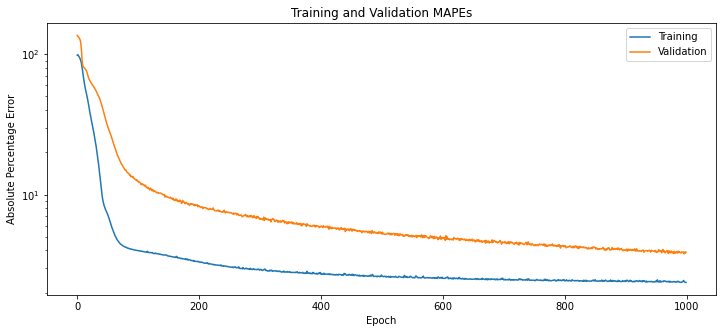

In [19]:
fig = plt.figure(figsize=(12,5))
plt.semilogy(LSTMhistory.history["mean_absolute_percentage_error"])
plt.semilogy(LSTMhistory.history["val_mean_absolute_percentage_error"])
plt.xlabel("Epoch")
plt.ylabel("Absolute Percentage Error")
plt.legend(["Training","Validation"])
plt.title('Training and Validation MAPEs')
plt.show()

In [20]:
min(LSTMhistory.history["val_mean_absolute_percentage_error"])

3.77908992767334

In [21]:
model = tf.keras.models.load_model("TScheckpoint.h5")

In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

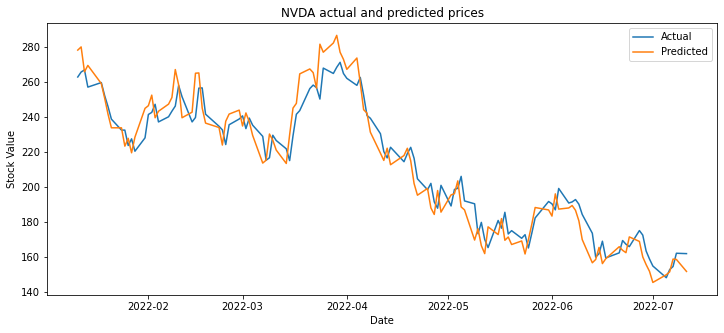

In [23]:
predictions = model_forecast(model, tf.expand_dims(series,-1), windowSize)
LSTMforecast = predictions[testStartTime - windowSize:-1, -1, 0]

fig = plt.figure(figsize=(12,5))
plt.plot(testDates,LSTMforecast)
plt.xlabel("Date")
plt.ylabel("Stock Value")
plt.plot(testDates,testValues)
plt.legend(["Actual","Predicted"])
plt.title(f'{ticker} actual and predicted prices')
plt.show()


In [24]:
LSTMMAPE = tf.keras.metrics.mean_absolute_percentage_error(testValues, LSTMforecast).numpy()
print(f"The Mean Absolute Percent Error for the LSTM is {LSTMMAPE}%")

The Mean Absolute Percent Error for the LSTM is 3.8648064136505127%


## Wavenet - Fully Convolutional Forecasting

Based off of WaveNet architecture. 

For an effective visualization: https://en.wikipedia.org/wiki/WaveNet#/media/File:WaveNet_animation.gif

In [25]:
windowSize = 1
batchSize = 32

train = windowDS(trainValues, batchSize, windowSize)
val = windowDS(valValues, batchSize, windowSize)

In [26]:
# Hidden Convolutional Layers
numConvBlocks = 6

In [27]:
tf.keras.backend.clear_session()
convModel = tf.keras.models.Sequential()
convModel.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilationRate in [2**i for i in range(numConvBlocks)]:
    convModel.add(
      tf.keras.layers.Conv1D(filters=16,
                          kernel_size=3,
                          strides=1,
                          dilation_rate=dilationRate,
                          padding="causal",
                          activation="relu")
    )
convModel.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))

In [28]:
convModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          64        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          784       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 16)          784       
                                                                 
 conv1d_3 (Conv1D)           (None, None, 16)          784       
                                                                 
 conv1d_4 (Conv1D)           (None, None, 16)          784       
                                                                 
 conv1d_5 (Conv1D)           (None, None, 16)          784       
                                                                 
 conv1d_6 (Conv1D)           (None, None, 1)           1

In [29]:
convOptimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)
convModel.compile(optimizer=convOptimizer,
              loss=tf.keras.losses.Huber(),
              metrics = [tf.keras.metrics.MeanAbsolutePercentageError()]
)

In [30]:
convModel_checkpoint = tf.keras.callbacks.ModelCheckpoint("TSConvcheckpoint.h5", save_best_only=True)

In [31]:
convHistory = convModel.fit(train,
                            epochs=500,
                            validation_data=val,
                            callbacks = [model_checkpoint,early_stopping, resetStates])

Epoch 1/500
35/35 [==============================] - 1s 13ms/step - loss: 94.5676 - mean_absolute_percentage_error: 100.0601 - val_loss: 246.9079 - val_mean_absolute_percentage_error: 100.0438
Epoch 2/500
35/35 [==============================] - 0s 4ms/step - loss: 94.5363 - mean_absolute_percentage_error: 100.0255 - val_loss: 246.8360 - val_mean_absolute_percentage_error: 100.0147
Epoch 3/500
35/35 [==============================] - 0s 4ms/step - loss: 94.5105 - mean_absolute_percentage_error: 99.9972 - val_loss: 246.7880 - val_mean_absolute_percentage_error: 99.9952
Epoch 4/500
35/35 [==============================] - 0s 4ms/step - loss: 94.4909 - mean_absolute_percentage_error: 99.9747 - val_loss: 246.7409 - val_mean_absolute_percentage_error: 99.9761
Epoch 5/500
35/35 [==============================] - 0s 4ms/step - loss: 94.4709 - mean_absolute_percentage_error: 99.9524 - val_loss: 246.6944 - val_mean_absolute_percentage_error: 99.9573
Epoch 6/500
35/35 [==========================

Epoch 44/500
35/35 [==============================] - 0s 5ms/step - loss: 91.2474 - mean_absolute_percentage_error: 96.5092 - val_loss: 237.9507 - val_mean_absolute_percentage_error: 96.4195
Epoch 45/500
35/35 [==============================] - 0s 5ms/step - loss: 90.8093 - mean_absolute_percentage_error: 96.0425 - val_loss: 236.7034 - val_mean_absolute_percentage_error: 95.9152
Epoch 46/500
35/35 [==============================] - 0s 5ms/step - loss: 90.2837 - mean_absolute_percentage_error: 95.4891 - val_loss: 235.1961 - val_mean_absolute_percentage_error: 95.3056
Epoch 47/500
35/35 [==============================] - 0s 5ms/step - loss: 89.6378 - mean_absolute_percentage_error: 94.8162 - val_loss: 233.3540 - val_mean_absolute_percentage_error: 94.5606
Epoch 48/500
35/35 [==============================] - 0s 5ms/step - loss: 88.8361 - mean_absolute_percentage_error: 93.9641 - val_loss: 230.9668 - val_mean_absolute_percentage_error: 93.5950
Epoch 49/500
35/35 [=========================

Epoch 88/500
35/35 [==============================] - 0s 4ms/step - loss: 1.6589 - mean_absolute_percentage_error: 2.1569 - val_loss: 5.2498 - val_mean_absolute_percentage_error: 2.1956
Epoch 89/500
35/35 [==============================] - 0s 5ms/step - loss: 1.6682 - mean_absolute_percentage_error: 2.1812 - val_loss: 5.2287 - val_mean_absolute_percentage_error: 2.1862
Epoch 90/500
35/35 [==============================] - 0s 4ms/step - loss: 1.6756 - mean_absolute_percentage_error: 2.1758 - val_loss: 5.2482 - val_mean_absolute_percentage_error: 2.1947
Epoch 91/500
35/35 [==============================] - 0s 4ms/step - loss: 1.6324 - mean_absolute_percentage_error: 2.1510 - val_loss: 5.2287 - val_mean_absolute_percentage_error: 2.1866
Epoch 92/500
35/35 [==============================] - 0s 4ms/step - loss: 1.6378 - mean_absolute_percentage_error: 2.1327 - val_loss: 5.2383 - val_mean_absolute_percentage_error: 2.1871
Epoch 93/500
35/35 [==============================] - 0s 4ms/step - lo

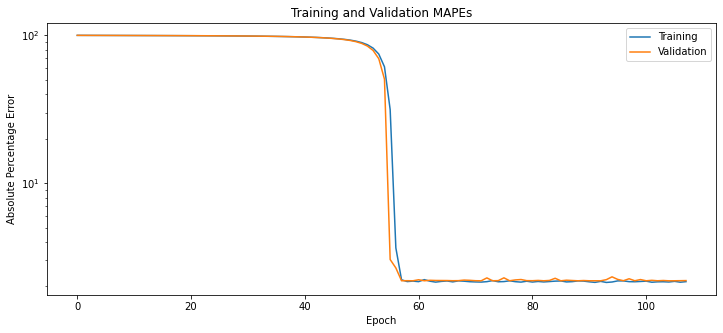

In [32]:
fig = plt.figure(figsize=(12,5))
plt.semilogy(convHistory.history["mean_absolute_percentage_error"])
plt.semilogy(convHistory.history["val_mean_absolute_percentage_error"])
plt.xlabel("Epoch")
plt.ylabel("Absolute Percentage Error")
plt.legend(["Training","Validation"])
plt.title('Training and Validation MAPEs')
plt.show()

In [33]:
min(convHistory.history["val_mean_absolute_percentage_error"])

2.1856138706207275

In [34]:
convModel = tf.keras.models.load_model("TSConvcheckpoint.h5")

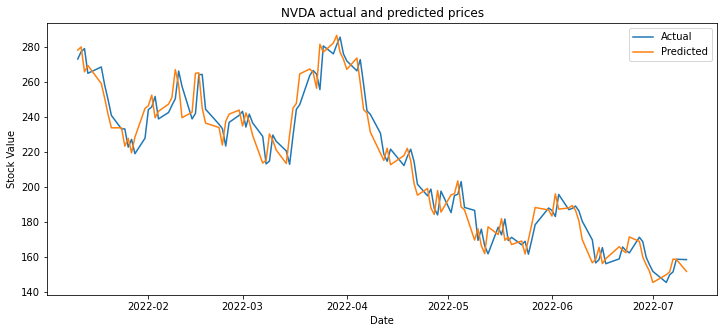

In [35]:
predictions = model_forecast(convModel, tf.expand_dims(series,-1), windowSize)
convForecast = predictions[testStartTime - windowSize:-1, -1, 0]

fig = plt.figure(figsize=(12,5))
plt.plot(testDates,convForecast)
plt.xlabel("Date")
plt.ylabel("Stock Value")
plt.plot(testDates,testValues)
plt.legend(["Actual","Predicted"])
plt.title(f'{ticker} actual and predicted prices')
plt.show()


In [36]:
convMAPE = tf.keras.metrics.mean_absolute_percentage_error(testValues, convForecast).numpy()
print(f"The Mean Absolute Percent Error for the deep CNN (Wavenet) is {convMAPE}%")

The Mean Absolute Percent Error for the deep CNN (Wavenet) is 3.5658493041992188%


In [37]:
convMAPE < nMAPE

True

# Conclusion

Only the Wavenet model was able to outperform the naive prediction, and not by a marginal amount. While this might seem discouraging, it could be an indication that the markets are efficient and that trading patterns are hard to detect. In general, naive forecasts may tend to be deceivingly difficult to beat, especially for certain stocks.

As a further suggestion, there might be opportunity to tweak the networks' architecture slightly or tune hyperparameters further. In addition, training and using such models on different tickers or different asset time series data (such as commodities) might yield better results. The intervals of time used above are one day, so using shorter intervals of time might also be worth investigating.